In [5]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Load the ATP dataset
data_path = "df_atp.csv"
df = pd.read_csv(data_path)

C:\Users\Sudharsana\AppData\Local\Temp\ipykernel_3640\241926977.py:3: DtypeWarning: Columns (15,21,22,28,31,47,48,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [11]:
# Data Cleaning
df = df[['Winner', 'Loser', 'Wsets', 'Lsets', 'B365W', 'B365L']]  # Select relevant columns
df = df.dropna()  # Drop rows with missing values
df['Outcome'] = 1  # Assign 'Winner' as 1
df['Opponent_Outcome'] = 0  # Assign 'Loser' as 0

In [13]:
# Combine winner and loser data for binary classification
df_winner = df[['Winner', 'B365W', 'Outcome']].rename(
    columns={'Winner': 'Player', 'B365W': 'Odds'})
df_loser = df[['Loser', 'B365L', 'Opponent_Outcome']].rename(
    columns={'Loser': 'Player', 'B365L': 'Odds', 'Opponent_Outcome': 'Outcome'})


In [15]:

# Merge winner and loser data
df_combined = pd.concat([df_winner, df_loser], ignore_index=True)

# Feature Engineering
df_combined['Implied_Probability'] = 1 / df_combined['Odds']

In [17]:
# Encode categorical variables
df_combined['Player'] = pd.factorize(df_combined['Player'])[0]

# Split dataset into features and target
X = df_combined[['Player', 'Implied_Probability']]
y = df_combined['Outcome']


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [21]:
# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6522660580371699
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      9185
           1       0.65      0.67      0.66      9217

    accuracy                           0.65     18402
   macro avg       0.65      0.65      0.65     18402
weighted avg       0.65      0.65      0.65     18402



In [23]:
# Betting Insights: Calculate value bets
def calculate_value_bet(odds, predicted_prob):
    return (odds * predicted_prob) - 1

X_test['Predicted_Prob'] = model.predict_proba(X_test)[:, 1]
X_test['Odds'] = X_test['Implied_Probability'].apply(lambda x: 1 / x)
X_test['Value_Bet'] = X_test.apply(lambda row: calculate_value_bet(row['Odds'], row['Predicted_Prob']), axis=1)

In [25]:
# Display top value bets
top_value_bets = X_test[X_test['Value_Bet'] > 0].sort_values(by='Value_Bet', ascending=False)
print("Top Value Bets:")
print(top_value_bets)

Top Value Bets:
       Player  Implied_Probability  Predicted_Prob   Odds  Value_Bet
75367     298             0.034483        0.560000  29.00  15.240000
62788     375             0.076923        0.740000  13.00   8.620000
81812     665             0.066667        0.610000  15.00   8.150000
87001     554             0.066667        0.590000  15.00   7.850000
66052     375             0.083333        0.730000  12.00   7.760000
...       ...                  ...             ...    ...        ...
16018      33             0.892857        0.893308   1.12   0.000505
67252     270             0.751880        0.752246   1.33   0.000488
6756       61             0.909091        0.909442   1.10   0.000386
48802      61             0.909091        0.909442   1.10   0.000386
85479     526             0.285714        0.285726   3.50   0.000042

[7622 rows x 5 columns]


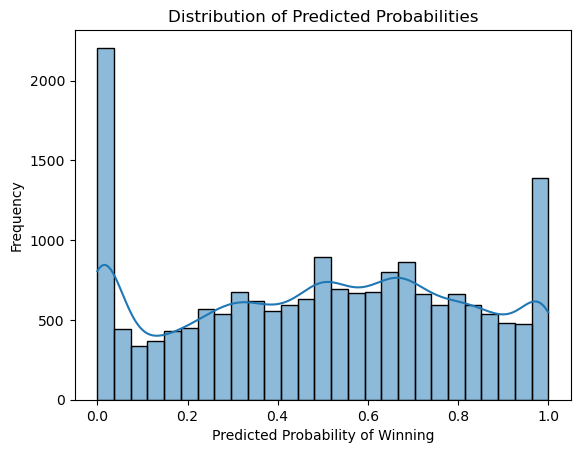

In [27]:
# Visualization: Distribution of predicted probabilities
sns.histplot(X_test['Predicted_Prob'], kde=True)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability of Winning")
plt.ylabel("Frequency")
plt.show()
